# Método de identificação descrito no trabalho da Carolina

Primeiramente é realizada a importação das bibliotecas e dados a serem utilizados para o cálculo do modelo:

## Importação de bibliotecas e dados e definição dos parâmetros:

In [188]:
# IMPORTAÇÃO DAS BIBLIOTECAS E DADOS

from scipy.io import *
from scipy import *
from numpy import *
from matplotlib.pyplot import *


mat = loadmat('data_LDMOS.mat')
in_ext = mat['in_extraction']
out_ext = mat['out_extraction']
in_val = mat['in_validation']
out_val = mat['out_validation']

# DEFINIÇÃO DOS PARÂMETROS DO MODELO
# nesse método de identificação basta definir o valor do efeito de memória M, já que não depende de P

M = 2

# n é o parâmetro que define o valor de Q (número de entradas da LUT), sendo Q=2^n

n = 2

# DEFINIÇÃO DO VETOR DE ENTRADA DAS LUTs
# é um vetor que varia igualmente de 0 a Q=2^n

e_lut = linspace(0,1,2**n)

A seguir são calculadas as matrizes x_nm e abs_x_nm. Essas matrizes são apenas os valores de entrada do vetor de extração considerando o efeito de memória. O único propósito de se definir essas matrizes agora é facilitar a implementação das próximas etapas.

\begin{equation}
x\_nm = 
\begin{bmatrix}
\tilde{x}(M+1) & \tilde{x}(M) & \dots & \tilde{x}(1)\\
 & \vdots & & \\
\tilde{x}(n) & \tilde{x}(n-M) & \dots & \tilde{x}(n-(M+1))\\
\end{bmatrix}
\end{equation}

\begin{equation}
abs\_x\_nm = 
\begin{bmatrix}
|\tilde{x}(M+1)| & |\tilde{x}(M)| & \dots & |\tilde{x}(1)|\\
 & \vdots & & \\
|\tilde{x}(n)| & |\tilde{x}(n-M)| & \dots & |\tilde{x}(n-(M+1))|\\
\end{bmatrix}
\end{equation}

In [189]:
# DEFINIÇÂO DAS MATRIZES CONTENDO OS VALORES DE x(n-m) e |x(n-m)|
def x_n_m(in_ext, M):
    x_nm = zeros((len(in_ext),(M+1)),dtype=complex)
    for r in range(M,len(in_ext)):
        for m in range(M+1):
            x_nm[r,m] = in_ext[r-m]
    return x_nm

x_nm  = x_n_m(in_ext,M)[M:len(in_ext),:]
abs_x_nm = abs(x_nm)

## Montagem da matriz $X_{LUT}$

Nessa etapa é montada a matriz $X_{LUT}$ seguindo o formato descrito no mestrado da Carolina:

\begin{equation}

    X_{LUT} = 
    \begin{bmatrix}
        1blocodeQcolunasdalinha1 & 2blocodeQcolunasdalinha1 & \dots & (M+1)-ésimoblocodeQcolunasdalinha1\\
         & \vdots & & \\
        1blocodeQcolunasdalinha(n-M) & 2blocodeQcolunasdalinha(n-M) & \dots & (M+1)-ésimoblocodeQcolunasdalinha(n-M)\\
    \end{bmatrix}  
    
    
\end{equation}

Os blocos de Q colunas devem ser preenchidos com os seguintes valores: 


\begin{equation}
    Valor_{(q-1)_{esimacoluna}} = \tilde{x}(n-m) \left[ 1 - \frac{[|\tilde{x}(n-m)| - e_{m(q-1)}]}{e_{m(q)} - e_{m(q-1)}} \right]
\end{equation}

\begin{equation}
    Valor_{(q)_{esimacoluna}} = \tilde{x}(n-m) \left[ \frac{[|\tilde{x}(n-m)| - e_{m(q-1)}]}{e_{m(q)} - e_{m(q-1)}} \right]
\end{equation}

E a inserção desses valores na matriz $X_{LUT}$ deve respeitar a condição $e_{m(q-1)} < |\tilde{x}(n-m)| < e_{m(q)}$.

A implementação foi realizada através de uma função denominada *xlut*. Essa função recebe como entrada as entradas da LUT, as matrizes x\_nm e abs\_x\_nm, o valor de M e o valor de n e retorna a matriz $X_{LUT}$.



In [190]:
def xlut(e_lut, x_nm, abs_x_nm, M, n):
    Q = 2**n
    #Nesse primero loop é calculado o primero bloco de Q colunas
    x_lut = zeros((len(x_nm),Q),dtype = "complex_")
    for r in range(len(x_nm)):
        for c in range(1,Q,2):
            #Aqui se aplica a condição mencionada anteriormente
            if e_lut[c-1] < abs_x_nm[r,0] < e_lut[c]:
                #As 2 próximas linhas são as formulas para os valores
                x_lut[r,c] = x_nm[r,0] * ((abs_x_nm[r,0] - e_lut[c-1])/((e_lut[c] - e_lut[c-1])))
                x_lut[r,c-1] = x_nm[r,0] * (1 - ((abs_x_nm[r,0] - e_lut[c-1])/((e_lut[c] - e_lut[c-1]))))

    #A partir daqui a função só continua se M>=1, os calculos se repetem para valores de M diferentes e os blocos calculados são juntados aos anteriores resultando na matriz X_LUT
    if M>=1:
        for m in range(1, M+1):
            x_lut_temp = zeros((len(x_nm),Q),dtype = "complex_")
            for r in range(len(x_nm)):
                for c in range(1,Q,2):
                    if e_lut[c-1] < abs_x_nm[r,m] < e_lut[c]:
                        x_lut_temp[r,c] = x_nm[r,m] * ((abs_x_nm[r,m] - e_lut[c-1])/((e_lut[c] - e_lut[c-1])))
                        x_lut_temp[r,c-1] = x_nm[r,m] * (1 - ((abs_x_nm[r,m] - e_lut[c-1])/((e_lut[c] - e_lut[c-1]))))

            x_lut = concatenate((x_lut,x_lut_temp), axis=1)                 
    return x_lut

x_lut = xlut(e_lut, x_nm, abs_x_nm, M, n)

## Cálculo das saídas da LUT

Com a matriz $X_{LUT}$ calculada obter as saídas complexas da LUT fica simples, apenas aplicamos a formula a seguir para realizar o MMQ: 


\begin{equation}
    s = (X_{LUT}^* X_{LUT})^{-1} (X_{LUT}^* Y) =
    \begin{bmatrix}
    \tilde{s}_{01} \\
    \vdots \\
    \tilde{s}_{0Q} \\
    \vdots \\
    \tilde{s}_{M1} \\
    \vdots \\
    \tilde{s}_{MQ}
    \end{bmatrix}
\end{equation}

A função *slut* aplica essa fórmula e separa os valores em uma matriz com Q linhas e 2*(M+1) colunas, separando as partes real e imaginária das saídas.

In [191]:
def slut(x_lut, out_ext, M, n):
    # A propriedade de matrizes .H do Numpy aplica o operador transposto complexo conjugado. A propriedade .I representa a matriz inversa.
    x1 = asmatrix(x_lut).H
    s_lut = asmatrix(x1@x_lut).I@asmatrix(x1@out_ext[M:len(out_ext),:])
    #s_lut = linalg.lstsq(x_lut,out_ext[M:len(out_ext),:], rcond=-1)
    #s_lut = s_lut[0]

    # Transformação do vetor s_lut em uma matriz de números reais.
    lut = empty((int(len(s_lut)/(M+1)), 2*(M+1)))
    rl = 0
    for c in range(1,2*(M+1),2):
        for r in range(2**n):
            lut[r,c] = imag(s_lut[rl])
            lut[r,c-1] = real(s_lut[rl])
            rl+=1
    return lut

s_lut = slut(x_lut, out_ext, M, n)

## Interpolação e validação

A partir desse ponto eu reaproveitei o código da IC anterior. Deixei a matriz da célula anterior no mesmo formato que utilizei no meu último trabalho para usar a mesma função de interpolação. Essa parte eu não me recordo 100% como foi implementada, portanto ainda preciso revisar.

In [192]:
def interpolacao(entrada,lut,M,n):
    Q = 2**n
    z = linspace(0,1,Q) 
    abs_in = np.abs(entrada)
    abs_in = abs_in[M:len(abs_in),:]
    inter = interp(abs_in,z,lut[:,0])
    for c in range(1,2*(M+1)):
        inter2 = interp(abs_in,z,lut[:,c])
        inter = append(inter,inter2,axis=1)
    
    real = zeros((len(inter),1))
    imag = zeros((len(inter),1))
    for c in range(0,2*(M+1),2):
        real = add(real,inter[:,c].reshape(len(inter),1))
        imag = add(imag,inter[:,c+1].reshape(len(inter),1))
    interpol = real + (imag * 1j)
    return interpol

inter = interpolacao(in_val,s_lut,M,n)
in_val_lut = in_val[M:len(in_val),:]
out_val_lut = out_val[M:len(out_val),:]
out_lut = inter*in_val_lut

## Resultados

A célula anterior já calcula a saída do modelo. Para finalizar só resta aplicar o NMSE:

In [193]:
def NMSE(previsao,validacao):
    erro = validacao - previsao
    erro = np.sum(np.absolute(erro)**2)
    val = np.sum(np.absolute(validacao)**2)
    res = 10*np.log10(erro/val)
    return res

NMSE_lut = NMSE(out_lut,out_val_lut)
print(NMSE_lut)

-9.435896781555616


Para simplificar a obtenção dos resultados juntei todos os passos na função a seguir e calculei o NMSE para diversos valores de M e n.

In [194]:
def identificacao_carolina(in_ext,out_ext,in_val,out_val,M,n):
    e_lut = linspace(0,1,2**n)
    x_nm  = x_n_m(in_ext,M)[M:len(in_ext),:]
    abs_x_nm = abs(x_nm)
    x_lut = xlut(e_lut, x_nm, abs_x_nm, M, n)
    s_lut = slut(x_lut, out_ext, M, n)
    inter = interpolacao(in_val,s_lut,M,n)
    in_val_lut = in_val[M:len(in_val),:]
    out_val_lut = out_val[M:len(out_val),:]
    out_lut = inter*in_val_lut
    NMSE_lut = NMSE(out_lut,out_val_lut)
    return NMSE_lut


def identificacao_carolina_relatorio(in_ext,out_ext,in_val,out_val,M,n):
    e_lut = linspace(0,1,2**n)
    print(f'in_ext (dados de entrada x): \n {in_ext} \n')
    x_nm  = x_n_m(in_ext,M)[M:len(in_ext),:]
    print(f'x_nm: \n {x_nm} \n')
    abs_x_nm = abs(x_nm)
    x_lut = xlut(e_lut, x_nm, abs_x_nm, M, n)
    print(f'X_lut: \n {x_lut} \n')
    s_lut = slut(x_lut, out_ext, M, n)
    print(f"Formato de s_lut (deve ser (2^n,2*(M+1)): {s_lut.shape} \n")
    inter = interpolacao(in_val,s_lut,M,n)
    in_val_lut = in_val[M:len(in_val),:]
    out_val_lut = out_val[M:len(out_val),:]
    out_lut = inter*in_val_lut
    NMSE_lut = NMSE(out_lut,out_val_lut)

    fig, (ax1, ax2) = subplots(1, 2)
    fig.suptitle(f'Gráficos AM-AM para M={M} e n={n}')
    ax1.plot(abs(out_lut),abs(in_val[M:len(in_val),:]))
    ax1.set_title("Saída calculada")
    ax2.plot(abs(out_val[M:len(out_val),:]),abs(in_val[M:len(in_val),:]))
    ax2.set_title("Saída esperada")
    show()

    print(f'\n NMSE={NMSE_lut}')
    print('\n ------------------------------------------------------------------- \n')
    return NMSE_lut

In [195]:
for n in range(1,5):
    for M in range(5):
        print(f'Para M={M} e n={n} -> NMSE={identificacao_carolina(in_ext,out_ext,in_val,out_val,M,n)}')

Para M=0 e n=1 -> NMSE=-31.46793378718492
Para M=1 e n=1 -> NMSE=-31.41583728741186
Para M=2 e n=1 -> NMSE=-31.403416959684648
Para M=3 e n=1 -> NMSE=-31.320244318870337
Para M=4 e n=1 -> NMSE=-31.30369924809653
Para M=0 e n=2 -> NMSE=-33.03152667733779
Para M=1 e n=2 -> NMSE=-14.347209322171107
Para M=2 e n=2 -> NMSE=-9.435896781555616
Para M=3 e n=2 -> NMSE=-6.51569608716994
Para M=4 e n=2 -> NMSE=-5.182913291456265
Para M=0 e n=3 -> NMSE=-35.05810527380092
Para M=1 e n=3 -> NMSE=-13.14183033437052
Para M=2 e n=3 -> NMSE=-8.361760116004687
Para M=3 e n=3 -> NMSE=-6.677968192519205
Para M=4 e n=3 -> NMSE=-5.977440822642331
Para M=0 e n=4 -> NMSE=-35.172627911548126
Para M=1 e n=4 -> NMSE=-10.175266362390381
Para M=2 e n=4 -> NMSE=-6.822265430495267
Para M=3 e n=4 -> NMSE=-5.583587088649937
Para M=4 e n=4 -> NMSE=-5.207441273706259


Para M=0 e n=2:

in_ext (dados de entrada x): 
 [[0.06874848-0.02982907j]
 [0.05495903-0.12721218j]
 [0.04307439-0.22773333j]
 ...
 [0.03853885-0.29324803j]
 [0.05741246-0.32447206j]
 [0.0849741 -0.34643166j]] 

x_nm: 
 [[0.06874848-0.02982907j]
 [0.05495903-0.12721218j]
 [0.04307439-0.22773333j]
 ...
 [0.03853885-0.29324803j]
 [0.05741246-0.32447206j]
 [0.0849741 -0.34643166j]] 

X_lut: 
 [[0.05329228-0.02312282j 0.0154562 -0.00670624j 0.        +0.j
  0.        +0.j        ]
 [0.03211095-0.07432634j 0.02284808-0.05288584j 0.        +0.j
  0.        +0.j        ]
 [0.01312419-0.06938727j 0.02995021-0.15834606j 0.        +0.j
  0.        +0.j        ]
 ...
 [0.00434299-0.03304648j 0.03419586-0.26020154j 0.        +0.j
  0.        +0.j        ]
 [0.00065814-0.00371953j 0.05675432-0.32075253j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]] 

Formato de s_lut (deve ser (2^n,2*(M+1)): (4, 2) 



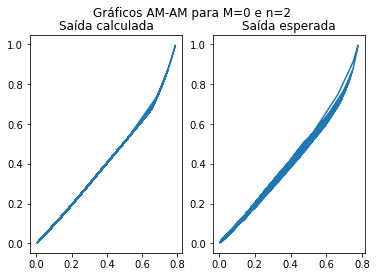


 NMSE=-33.03152667733779

 ------------------------------------------------------------------- 

Para M=1 e n=2:

in_ext (dados de entrada x): 
 [[0.06874848-0.02982907j]
 [0.05495903-0.12721218j]
 [0.04307439-0.22773333j]
 ...
 [0.03853885-0.29324803j]
 [0.05741246-0.32447206j]
 [0.0849741 -0.34643166j]] 

x_nm: 
 [[0.05495903-0.12721218j 0.06874848-0.02982907j]
 [0.04307439-0.22773333j 0.05495903-0.12721218j]
 [0.03618911-0.32025965j 0.04307439-0.22773333j]
 ...
 [0.03853885-0.29324803j 0.02961346-0.25725862j]
 [0.05741246-0.32447206j 0.03853885-0.29324803j]
 [0.0849741 -0.34643166j 0.05741246-0.32447206j]] 

X_lut: 
 [[0.03211095-0.07432634j 0.02284808-0.05288584j 0.        +0.j
  ... 0.0154562 -0.00670624j 0.        +0.j
  0.        +0.j        ]
 [0.01312419-0.06938727j 0.02995021-0.15834606j 0.        +0.j
  ... 0.02284808-0.05288584j 0.        +0.j
  0.        +0.j        ]
 [0.00119809-0.01060268j 0.03499101-0.30965697j 0.        +0.j
  ... 0.02995021-0.15834606j 0.        +0.

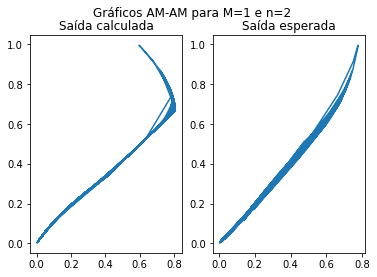


 NMSE=-14.347209322171107

 ------------------------------------------------------------------- 



In [196]:
n=2
for M in range(2):
    print(f'Para M={M} e n={n}:\n')
    identificacao_carolina_relatorio(in_ext,out_ext,in_val,out_val,M,n)